In [1]:
import torch
print(torch.__version__)
print(torch.cuda.is_available(), torch.cuda.get_device_name(0))


2.8.0+cu126
True Tesla T4


MOUNT GOOGLE DRIVE

In [1]:
from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


In [3]:
image_path = "/content/drive/MyDrive/Dataset of Tuberculosis Chest X-rays Images/Normal Chest X-rays/others (1).jpg"


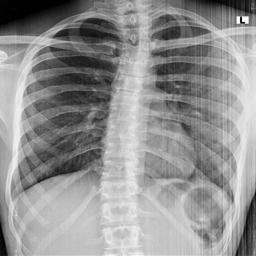

Filename: /content/drive/MyDrive/Dataset of Tuberculosis Chest X-rays Images/Normal Chest X-rays/others (1).jpg
Size: (256, 256)
Format: JPEG
Mode: RGB


In [ ]:
from PIL import Image

# Open the image
img = Image.open(image_path)

# Display the image (inline in Colab)
display(img)

# Print basic info
print("Filename:", img.filename)
print("Size:", img.size)      # (width, height)
print("Format:", img.format)
print("Mode:", img.mode)




Split into TRAIN, TEST, AND VALIDATE SET




In [2]:
from sklearn.model_selection import train_test_split
import os


In [3]:
tb_dir = "/content/drive/MyDrive/Dataset of Tuberculosis Chest X-rays Images/TB Chest X-rays"
normal_dir = "/content/drive/MyDrive/Dataset of Tuberculosis Chest X-rays Images/Normal Chest X-rays"


# 3. Get image lists for TB and Normal classes
tb_images = [f for f in os.listdir(tb_dir) if f.endswith('.jpg')]
normal_images = [f for f in os.listdir(normal_dir) if f.endswith('.jpg')]

# 4. Split TB images: 80% train, then 10% of train for val (so 72/8/20 split)
tb_train, tb_test = train_test_split(tb_images, test_size=0.2, random_state=42)
tb_train, tb_val  = train_test_split(tb_train,  test_size=0.1, random_state=42)

# 5. Split Normal images with same ratios
normal_train, normal_test = train_test_split(normal_images, test_size=0.2, random_state=42)
normal_train, normal_val  = train_test_split(normal_train,  test_size=0.1, random_state=42)

print(f"TB   -> Train: {len(tb_train)}, Val: {len(tb_val)}, Test: {len(tb_test)}")
print(f"Norm -> Train: {len(normal_train)}, Val: {len(normal_val)}, Test: {len(normal_test)}")

TB   -> Train: 1795, Val: 200, Test: 499
Norm -> Train: 369, Val: 42, Test: 103


ORGANISING ALL SPLITS IN A FOLDER _ DATASET

In [4]:
import shutil

# Source directories containing all TB and Normal images
tb_source = "/content/drive/MyDrive/Dataset of Tuberculosis Chest X-rays Images/TB Chest X-rays"
normal_source = "/content/drive/MyDrive/Dataset of Tuberculosis Chest X-rays Images/Normal Chest X-rays"

# Define splits (fill with your split lists)
splits = {
    "train": {"TB": tb_train, "Normal": normal_train},
    "val": {"TB": tb_val, "Normal": normal_val},
    "test": {"TB": tb_test, "Normal": normal_test},
}

In [5]:
# Create folder structure and copy images
for split_name, split_classes in splits.items():
    for class_name, file_list in split_classes.items():
        dest_folder = os.path.join("dataset", split_name, class_name)
        os.makedirs(dest_folder, exist_ok=True)
        source_folder = tb_source if class_name == "TB" else normal_source
        for file in file_list:
            src_file = os.path.join(source_folder, file)
            if os.path.exists(src_file):
                shutil.copy(src_file, dest_folder)
            else:
                print(f"Warning: {src_file} not found, skipped.")

print("All splits have been organized successfully.")


All splits have been organized successfully.


In [6]:
import os
print(os.listdir("/content"))
print(os.listdir("/content/dataset"))


['.config', 'dataset', 'drive', 'sample_data']
['val', 'test', 'train']


In [6]:
import os
import cv2
import albumentations as A
from tqdm import tqdm

# Augmentation and preprocessing pipeline
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.Rotate(limit=20, p=0.5),
    A.RandomGamma(p=0.2),
    A.Resize(224, 224),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0),
])

# Source root and output root for cleaned files
data_root = "/content/dataset"
sets = ['train', 'val']
output_root = os.path.join(data_root, "processed")
n_augment = 3

In [7]:
for set_name in sets:
    input_dir = os.path.join(data_root, set_name)
    for subdir, _, files in os.walk(input_dir):
        # Identify subfolder class name by relative path
        rel_subdir = os.path.relpath(subdir, input_dir)
        if rel_subdir == ".":
            rel_subdir = ""
        # Make corresponding output subdir
        out_subdir = os.path.join(output_root, set_name, rel_subdir)
        os.makedirs(out_subdir, exist_ok=True)
        imgs = [f for f in files if f.lower().endswith('.jpg')]
        for img_name in tqdm(imgs, desc=f"{set_name} / {rel_subdir}"):
            img_path = os.path.join(subdir, img_name)
            image = cv2.imread(img_path)
            if image is None:
                continue
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            for aug_idx in range(n_augment):
                augmented = transform(image=image)
                aug_image = augmented['image']
                # Convert normalized image to uint8
                aug_image = ((aug_image - aug_image.min()) / (aug_image.max() - aug_image.min()) * 255.0).astype('uint8')
                out_filename = f"{os.path.splitext(img_name)[0]}_aug{aug_idx+1}.jpg"
                out_path = os.path.join(out_subdir, out_filename)
                cv2.imwrite(out_path, cv2.cvtColor(aug_image, cv2.COLOR_RGB2BGR))

print("Augmentation, resizing, and standardization finished for train/val with subfolders!")

train / : 0it [00:00, ?it/s]
train / Normal: 100%|██████████| 369/369 [00:03<00:00, 106.97it/s]
val / : 0it [00:00, ?it/s]
val / Normal: 100%|██████████| 42/42 [00:00<00:00, 131.39it/s]

Augmentation, resizing, and standardization finished for train/val with subfolders!


PREPROCESSING TEST SET

In [8]:
import os
import cv2
import albumentations as A
from tqdm import tqdm

# Resize and normalization pipeline (no augmentation)
transform = A.Compose([
    A.Resize(224, 224),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0),
])

data_root = "/content/dataset"
input_dir = os.path.join(data_root, 'test')
output_dir = os.path.join(data_root, 'processed', 'test')

In [9]:
for subdir, _, files in os.walk(input_dir):
    rel_subdir = os.path.relpath(subdir, input_dir)
    # Skip directories with no images
    imgs = [f for f in files if f.lower().endswith('.jpg')]
    if not imgs:
        continue
    out_subdir = os.path.join(output_dir, rel_subdir)
    os.makedirs(out_subdir, exist_ok=True)
    for img_name in tqdm(imgs, desc=f"test / {rel_subdir}"):
        img_path = os.path.join(subdir, img_name)
        image = cv2.imread(img_path)
        if image is None:
            continue
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        augmented = transform(image=image)
        out_image = augmented['image']
        # Convert normalized image to uint8 for saving
        out_image = ((out_image - out_image.min()) / (out_image.max() - out_image.min()) * 255.0).astype('uint8')
        out_path = os.path.join(out_subdir, img_name)
        cv2.imwrite(out_path, cv2.cvtColor(out_image, cv2.COLOR_RGB2BGR))

print("Resizing and standardization finished for test set!")


test / Normal: 100%|██████████| 103/103 [00:00<00:00, 427.52it/s]

Resizing and standardization finished for test set!


EDA (Exploratory Data Analysis)

TRAINING SET DISTRIBUTION

Image counts by class:
  TB: 1795
  Normal: 369
  Total: 2164


/tmp/ipython-input-1438992946.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['TB', 'Normal'], y=[tb_count, normal_count], palette='viridis')


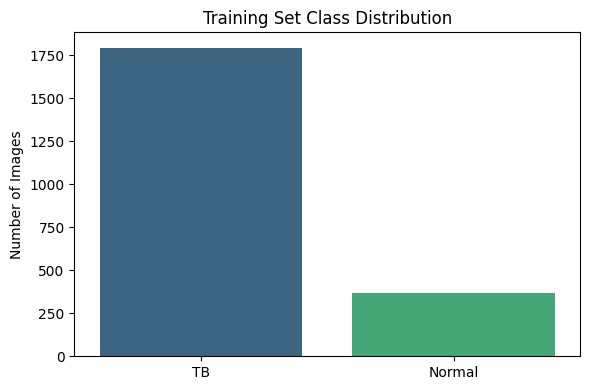

In [13]:
# --- CLASS BALANCE & IMAGE DISTRIBUTION ---
import os
import matplotlib.pyplot as plt
import seaborn as sns

# Folders for each class
train_tb_folder = "/content/dataset/train/TB"
train_normal_folder = "/content/dataset/train/Normal"

# Count images per class
tb_images_list = [f for f in os.listdir(train_tb_folder) if f.endswith('.jpg')]
normal_images_list = [f for f in os.listdir(train_normal_folder) if f.endswith('.jpg')]

tb_count = len(tb_images_list)
normal_count = len(normal_images_list)

print("Image counts by class:")
print(f"  TB: {tb_count}")
print(f"  Normal: {normal_count}")
print(f"  Total: {tb_count + normal_count}")

# Visualize as bar plot
plt.figure(figsize=(6, 4))
sns.barplot(x=['TB', 'Normal'], y=[tb_count, normal_count], palette='viridis')
plt.title('Training Set Class Distribution')
plt.ylabel('Number of Images')
plt.tight_layout()
plt.show()

So if your original test folders are:

/content/dataset/test/TB

/content/dataset/test/Normal

then the processed folders become:

/content/dataset/processed/test/TB

/content/dataset/processed/test/Normal

**Summary Statistics,**
**Pixel intensity Distribution**

In [ ]:
import numpy as np

def load_all_images(folder):
    imgs = []
    for root, _, files in os.walk(folder):
        for f in files:
            if f.lower().endswith('.jpg'):
                path = os.path.join(root, f)
                img = cv2.imread(path)
                if img is None:
                    continue
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                imgs.append(img)
    return np.stack(imgs) if imgs else np.empty((0, 224, 224, 3))

train_root = "/content/dataset/processed/train"
tb_images = load_all_images(os.path.join(train_root, "TB"))
normal_images = load_all_images(os.path.join(train_root, "Normal"))

Normalized TB image pixel stats:
Red: min=0.000, max=243.000, mean=128.735, std=62.695
Green: min=0.000, max=251.000, mean=136.554, std=64.040
Blue: min=11.000, max=255.000, mean=149.626, std=63.805

Normalized Normal image pixel stats:
Red: min=0.000, max=242.000, mean=119.803, std=53.256
Green: min=0.000, max=250.000, mean=126.898, std=54.346
Blue: min=11.000, max=255.000, mean=139.190, std=54.023


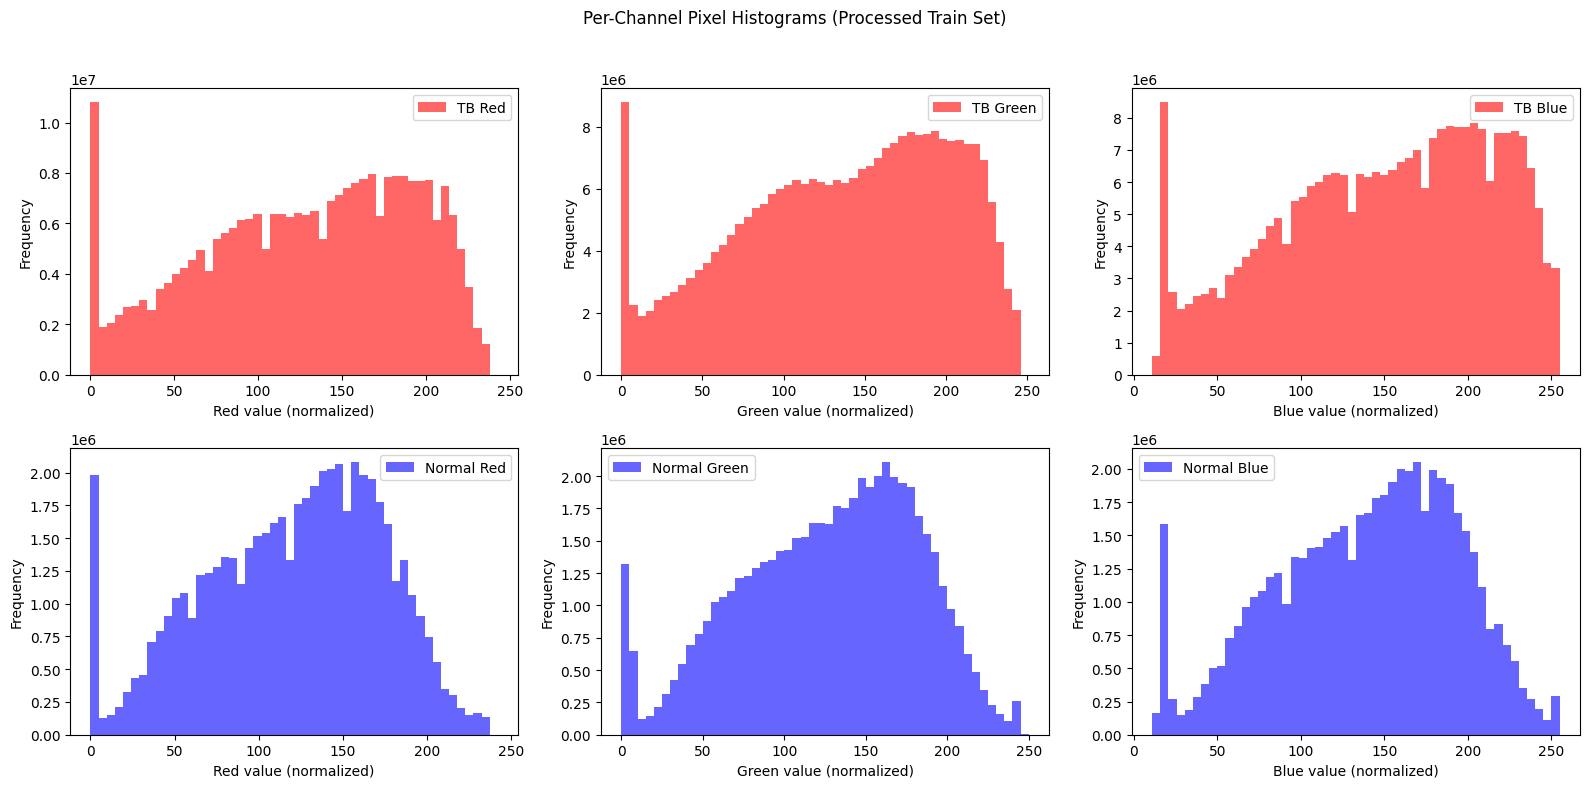

In [ ]:
# Reshape to single long vector per channel
tb_pixels = tb_images.reshape(-1, 3)
normal_pixels = normal_images.reshape(-1, 3)

# Pixel stats per channel
channels = ['Red', 'Green', 'Blue']
print("Normalized TB image pixel stats:")
for i, c in enumerate(channels):
    print(f"{c}: min={tb_pixels[:,i].min():.3f}, max={tb_pixels[:,i].max():.3f}, mean={tb_pixels[:,i].mean():.3f}, std={tb_pixels[:,i].std():.3f}")
print("\nNormalized Normal image pixel stats:")
for i, c in enumerate(channels):
    print(f"{c}: min={normal_pixels[:,i].min():.3f}, max={normal_pixels[:,i].max():.3f}, mean={normal_pixels[:,i].mean():.3f}, std={normal_pixels[:,i].std():.3f}")

# Channel-wise histograms
plt.figure(figsize=(16, 8))
for i, c in enumerate(channels):
    plt.subplot(2, 3, i+1)
    plt.hist(tb_pixels[:, i], bins=50, color='red', alpha=0.6, label=f'TB {c}')
    plt.xlabel(f"{c} value (normalized)")
    plt.ylabel("Frequency")
    plt.legend()
    plt.subplot(2, 3, i+4)
    plt.hist(normal_pixels[:, i], bins=50, color='blue', alpha=0.6, label=f'Normal {c}')
    plt.xlabel(f"{c} value (normalized)")
    plt.ylabel("Frequency")
    plt.legend()
plt.suptitle("Per-Channel Pixel Histograms (Processed Train Set)")
plt.tight_layout(rect=[0,0,1,0.96])
plt.show()

**Image Dimensions and Visual Samples,**
**Display Random Samples:**

In [ ]:
def load_images(folder):
    imgs = []
    for root, _, files in os.walk(folder):
        for f in files:
            if f.lower().endswith('.jpg'):
                img = cv2.imread(os.path.join(root, f))
                if img is None: continue
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                imgs.append(img)
    return np.stack(imgs) if imgs else np.empty((0, 224, 224, 3))

# Paths for each class
train_root = "/content/dataset/processed/train"
tb_images = load_images(os.path.join(train_root, "TB"))
normal_images = load_images(os.path.join(train_root, "Normal"))

print(f"TB images: {tb_images.shape}")
print(f"Normal images: {normal_images.shape}")


TB images: (5385, 224, 224, 3)
Normal images: (1107, 224, 224, 3)


All cleaned images have consistent shape: (224, 224, 3)


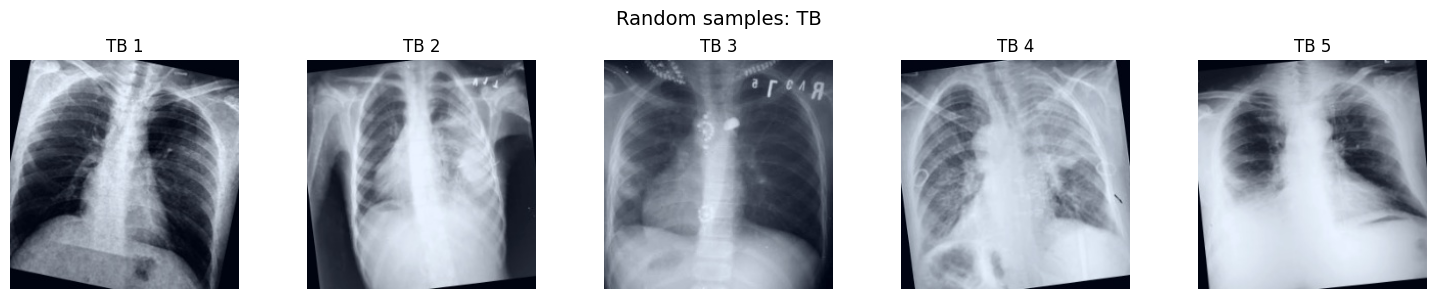

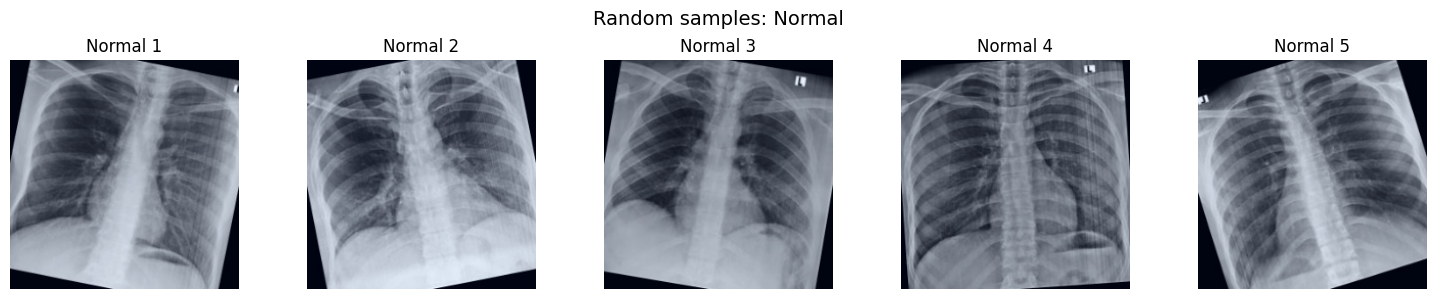

In [ ]:
if tb_images.shape[1:] == normal_images.shape[1:]:
    print("All cleaned images have consistent shape:", tb_images.shape[1:])

# Visualize clean samples side-by-side
def show_samples(image_stack, label, num_samples=5):
    idxs = np.random.choice(image_stack.shape[0], min(num_samples, image_stack.shape[0]), replace=False)
    plt.figure(figsize=(3*num_samples,3))
    for i, idx in enumerate(idxs):
        img_norm = image_stack[idx]
        # Undo normalization for display if needed, else just clip between 0 and 255
        img_disp = np.clip(img_norm, 0, 255).astype(np.uint8)
        plt.subplot(1, num_samples, i+1)
        plt.imshow(img_disp)
        plt.axis('off')
        plt.title(f"{label} {i+1}", fontsize=12)
    plt.suptitle(f"Random samples: {label}", fontsize=14)
    plt.tight_layout()
    plt.show()

show_samples(tb_images, "TB")
show_samples(normal_images, "Normal")

MODELING

**Model = ResNet50**
with Training Loss

In [10]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import models
from PIL import Image
import torch.nn as nn

class TBImageDataset(Dataset):
    def __init__(self, root):
        self.samples = []
        self.labels = []
        for label, subdir in enumerate(['Normal', 'TB']):
            folder = os.path.join(root, subdir)
            for root_, _, files in os.walk(folder):
                for f in files:
                    if f.lower().endswith('.jpg'):
                        self.samples.append(os.path.join(root_, f))
                        self.labels.append(label)
    def __getitem__(self, idx):
        img = Image.open(self.samples[idx]).convert('RGB')
        img = torch.from_numpy(np.array(img)).permute(2, 0, 1).float()  # (C, H, W)
        label = self.labels[idx]
        return img, label
    def __len__(self):
        return len(self.samples)


In [11]:
# Paths
train_dir = "/content/dataset/processed/train"

# Dataset and loader
train_dataset = TBImageDataset(train_dir)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

In [12]:
# Load pretrained ResNet
device = torch.device('cuda')
model = models.resnet50(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 2)  # 2 classes: TB and Normal
model = model.to(device)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 134MB/s]


RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx

In [ ]:
# Loss & optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Training loop
for epoch in range(5):
    model.train()
    running_loss = 0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1} Loss: {running_loss/len(train_loader):.4f}")

torch.save(model.state_dict(), "tb_resnet_model.pth")

Epoch 1 Loss: 0.0374
Epoch 2 Loss: 0.0159
Epoch 3 Loss: 0.0052
Epoch 4 Loss: 0.0077
Epoch 5 Loss: 0.0084


In [ ]:
# --- Validation Loss Calculation ---

val_dir = "/content/dataset/processed/val"
val_dataset = TBImageDataset(val_dir)  # Use your already defined class
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

model.load_state_dict(torch.load("tb_resnet_model.pth"))
model.eval()

val_loss, total = 0.0, 0

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        val_loss += loss.item() * labels.size(0)
        total += labels.size(0)

print(f"Validation Loss: {val_loss / total:.4f}")



Validation Loss: 0.0079


**MODEL = VGG16**
with Training Loss

In [13]:
# Load pretrained VGG16 and adapt final layer
from torchvision import models
device = torch.device('cuda')
model = models.vgg16(pretrained=True)
model.classifier[6] = nn.Linear(model.classifier[6].in_features, 2)  # 2 classes
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


100%|██████████| 528M/528M [00:07<00:00, 72.8MB/s]


RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx

In [ ]:
# Standard training loop
for epoch in range(5):
    model.train()
    running_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {running_loss / len(train_loader):.4f}")

torch.save(model.state_dict(), "tb_vgg16_model.pth")


Epoch 1, Loss: 0.2235
Epoch 2, Loss: 0.1408
Epoch 3, Loss: 0.0364
Epoch 4, Loss: 0.0260
Epoch 5, Loss: 0.0383


In [ ]:
# --- Validation Loss Calculation ---

model.eval()                       # evaluation mode
val_loss = 0.0
n_samples = 0

with torch.no_grad():              # no gradients for validation
    for x, y in val_loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        loss = criterion(logits, y)

        batch_size = y.size(0)
        val_loss += loss.item() * batch_size
        n_samples += batch_size

val_loss /= n_samples              # average loss over all val samples
print(f"Validation loss: {val_loss:.4f}")


Validation loss: 0.0643


**MODEL = EfficientNetB0**
with Training loss

In [14]:
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
weights = EfficientNet_B0_Weights.DEFAULT
model = efficientnet_b0(weights=weights)              # pretrained ImageNet

num_ftrs = model.classifier[1].in_features            # final FC layer
model.classifier[1] = nn.Linear(num_ftrs, 2)          # 2 classes: TB, Normal
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 85.9MB/s]


RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx

In [ ]:
# Standard training loop (uses your existing train_loader with 224x224 images)
for epoch in range(5):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {running_loss / len(train_loader):.4f}")

torch.save(model.state_dict(), "tb_efficientnet_b0_model.pth")

Epoch 1, Loss: 0.0712
Epoch 2, Loss: 0.0078
Epoch 3, Loss: 0.0034
Epoch 4, Loss: 0.0040
Epoch 5, Loss: 0.0009


In [ ]:
# --- Validation Loss Calculation ---

model.eval()                     # evaluation mode
val_loss = 0.0
n_samples = 0

with torch.no_grad():            # no gradients for validation
    for x, y in val_loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        loss = criterion(logits, y)

        batch_size = y.size(0)
        val_loss += loss.item() * batch_size
        n_samples += batch_size

val_loss /= n_samples            # average loss over all val samples
print(f"Validation loss: {val_loss:.4f}")


Validation loss: 0.0162


ResNet shows the tightest train-validation gap (0.0005), indicating minimal overfitting and strong generalization. VGG16 has the highest losses and a negative gap suggesting underfitting or data mismatch. EfficientNet achieves the lowest final train loss but higher validation loss, risking poorer real-world performance.

In [16]:
import numpy as np

In [17]:
test_dir = "/content/dataset/processed/test"
test_dataset = TBImageDataset(test_dir)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [18]:
import torch
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

device = torch.device("cuda")
model.to(device)
model.eval()

all_labels = []
all_preds = []

with torch.no_grad():
    for images, labels in test_loader:   # or test_loader
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)              # shape: [batch_size, 2]
        _, preds = torch.max(outputs, 1)     # predicted class indices

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

# Convert lists to numpy arrays (sklearn needs this)
y_true = np.array(all_labels)
y_pred = np.array(all_preds)

# Binary classification metrics
accuracy  = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, pos_label=1)  # 1 = TB
recall    = recall_score(y_true, y_pred, pos_label=1)
f1        = f1_score(y_true, y_pred, pos_label=1)

print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1-score : {f1:.4f}")


Accuracy : 0.7309
Precision: 0.8173
Recall   : 0.8697
F1-score : 0.8427


In [21]:
import os

print(os.listdir("/content"))
print(os.path.isfile("/content/tb_resnet_final.pth"))


['.config', 'dataset', 'drive', 'tb_resnet_final.pth', 'sample_data']
True


In [15]:
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'epoch': 5,
}, 'tb_resnet_final.pth')


NameError: name 'optimizer' is not defined

In [22]:
!pip install streamlit torch torchvision pillow


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 53.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 108.8 MB/s eta 0:00:00


In [23]:
!pip install pyngrok

In [24]:
%%writefile app.py

import streamlit as st
import torch
import torch.nn as nn
from torchvision import models, transforms
from PIL import Image
import numpy as np

# ---------------- Page configuration ----------------
st.set_page_config(page_title="TB Detection", page_icon="🫁", layout="wide")

# ---------------- Model loading ----------------
@st.cache_resource
def load_model():
    # MUST match training code: ResNet18 + 2 output classes
    model = models.resnet18(pretrained=False)   # <--- use resnet18, not resnet50
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 2)           # TB vs Normal

    checkpoint = torch.load("tb_resnet_final.pth", map_location="cpu")

    # Support both ways of saving
    if isinstance(checkpoint, dict) and "model_state_dict" in checkpoint:
        state_dict = checkpoint["model_state_dict"]
    else:
        state_dict = checkpoint

    model.load_state_dict(state_dict)
    model.eval()
    return model

# ---------------- Preprocessing ----------------
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

def predict_image(model, image):
    image = image.convert("RGB")
    image = transform(image).unsqueeze(0)

    with torch.no_grad():
        outputs = model(image)
        probabilities = torch.nn.functional.softmax(outputs[0], dim=0)
        confidence = torch.max(probabilities).item()
        pred_idx = torch.argmax(probabilities).item()
        prediction = "TB" if pred_idx == 1 else "Normal"

    return prediction, confidence

# ---------------- Page selection ----------------
page = st.sidebar.selectbox("Choose a page", ["🏠 Introduction", "🔬 TB Prediction"])

# ---------------- Introduction page ----------------
if page == "🏠 Introduction":
    st.title("🫁 Tuberculosis Detection from Chest X-rays")
    st.markdown("""
    ## Welcome to TB-Detect AI

    This app uses a **ResNet18 deep learning model** trained on chest X-ray images
    to detect tuberculosis (TB) vs Normal cases.

    ### How it works:
    - Upload your chest X-ray image
    - The model analyzes lung patterns
    - You get a prediction with confidence score

    **Ready to test?** → Go to **TB Prediction** page!
    """)

    col1, col2 = st.columns(2)
    with col1:
        st.info("✅ Upload any chest X-ray (JPG, PNG)")
        st.success("🎯 Binary classification: TB vs Normal")
    with col2:
        st.warning("⚠️ Medical disclaimer: For research/demo only. Not for clinical use.")

# ---------------- Prediction page ----------------
elif page == "🔬 TB Prediction":
    st.title("🔬 Upload Chest X-ray for TB Detection")

    uploaded_file = st.file_uploader(
        "Choose a chest X-ray image...",
        type=["png", "jpg", "jpeg"],
        help="Upload JPG/PNG chest X-ray image"
    )

    if uploaded_file is not None:
        image = Image.open(uploaded_file)
        st.image(image, caption="Uploaded Chest X-ray", use_column_width=True)

        with st.spinner("Analyzing image..."):
            model = load_model()
            prediction, confidence = predict_image(model, image)

            col1, col2, col3 = st.columns([1, 2, 1])

            with col1:
                st.markdown("**Prediction:**")
            with col2:
                if prediction == "TB":
                    st.error(f"🦠 **{prediction}**")
                else:
                    st.success(f"✅ **{prediction}**")
            with col3:
                st.markdown("**Confidence:**")
                st.metric("Confidence", f"{confidence:.1%}")

            st.markdown("---")
            st.info(f"""
            **Result Details:**
            - Prediction: **{prediction}**
            - Confidence: **{confidence:.1%}**
            - Model: **ResNet18** (best performing in your training)

            *Upload another image to test more cases!*
            """)

# ---------------- Footer ----------------
st.markdown("---")
st.markdown("*Powered by ResNet18 • Developed for TB Detection Research*")


Writing app.py


In [ ]:
!pip install cloudflared
!pip install streamlit -q
!wget -q -O cloudflared.deb https://github.com/cloudflare/cloudflared/releases/latest/download/cloudflared-linux-amd64.deb
!dpkg -i cloudflared.deb

!streamlit run /content/app.py &>/content/logs.txt &
!sleep 3
!cloudflared tunnel --url http://localhost:8501 --no-autoupdate

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 kB 3.0 MB/s eta 0:00:00
  Created wheel for cloudflared: filename=cloudflared-1.0.0.2-py3-none-any.whl size=2983 sha256=5a1838440708b6d76bede73a31f097e5c6ec26e5e1cfef0290ae1bc905928c61
  Stored in directory: /root/.cache/pip/wheels/5b/ec/09/c3bcd3470be046ec77a9c0cb9d8bb6ceed49c831460878ab0a
Successfully built cloudflared
Selecting previously unselected package cloudflared.
(Reading database ... 121713 files and directories currently installed.)
Preparing to unpack cloudflared.deb ...
Unpacking cloudflared (2025.11.1) ...
Setting up cloudflared (2025.11.1) ...
Processing triggers for man-db (2.10.2-1) ...
2025-11-29T11:21:45Z INF Thank you for trying Cloudflare Tunnel. Doing so, without a Cloudflare account, is a quick way to experiment and try it out. However, be aware that these account-less Tunnels have no uptime guarantee, are subject to the Cloudflare Online Services Terms of Use (https:/